In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import lognorm

import sys
sys.path.append("..")
from utils import *
from chain import *

In [94]:
def get_renewal(waitTs, T):
    """
    Given a collection of waiting / inter-spike times
    get a instance of a renewal process with this collection of waiting times
    till time 'T'
    return the jumping times
    """
    jumps = np.cumsum(waitTs)
    endpoints = np.hstack(([0], jumps[jumps<T], [T]))
    return endpoints

In [49]:
class aDDModel(object):
    def __init__(self, rl, rr, theta, endpoints, sigma=1) -> None:
        self.mu1 = rl - theta * rr
        self.mu2 = -rr + theta * rl
        self.sigma = sigma
        self.mu_t = lambda t: mu_pc(t, self.mu1, self.mu2, endpoints)
        
    def gen_datum(self, a, z, dt=0.001):
        t, u = 0, z
        while u > -a and u < a:
            dW = np.random.normal(loc=0.0, scale=np.sqrt(dt))
            u += self.mu_t(t) * dt + self.sigma * dW
            t += dt
        return np.hstack((t, (u > a / 2) * a))
    
    def gen_data(self, a, z, num=1000, dt=0.001):
        data = np.zeros((num, 2))
        for i in range(num):
            data[i] = self.gen_datum(a, z, dt)
        return data
    
    def gen_trajs(self, z, T, Nt=1000, num=10):
        """
        Use strong Euler to simulate
        only used for visualization
        """
        trajs = []
        t0, u0 = 0, z
        dt = (T - t0) / Nt
        t_grid = np.arange(t0, T + dt, dt)
        for i in range(num):
            dW = np.sqrt(dt) * np.random.normal(size=(Nt + 1,))
            du = self.mu_t(t_grid) * dt + self.sigma * dW
            u_grid = z + np.cumsum(du)
            trajs.append(np.array([t_grid, u_grid]))
        return np.array(trajs)

### Visualize

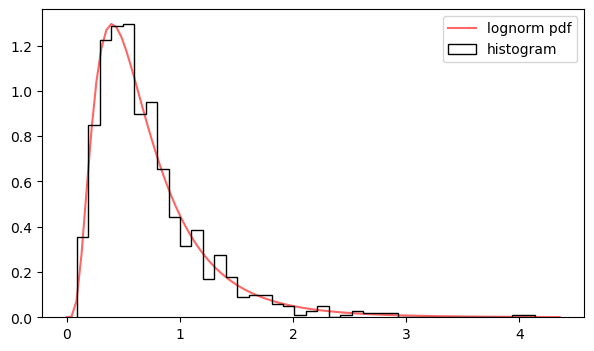

In [114]:
# sample lognormal waiting times and visualize
mu = 6.39 
sigma = 0.63

rng = np.random.default_rng()
waitTs = rng.lognormal(mean=mu, sigma=sigma, size=1000) / 1000

fig, ax = plt.subplots(figsize=(7, 4))
x = np.linspace(0, np.max(isis), 100)
ax.plot(
    x,
    lognorm.pdf(x, s=sigma, scale=np.exp(mu + np.log(1 / 1000))),
    "r-",
    alpha=0.6,
    label="lognorm pdf",
)
ax.hist(waitTs, histtype="step", bins=40, color="black", density=True, label='histogram')
ax.legend()
plt.show()

In [125]:
rl, rr = 7, 7
theta = 0.6
mu1 = rl - theta * rr
mu2 = -rr + theta * rl
sigma = np.sqrt(0.05 ** 2 / 0.005)
a = 1.0
z = 0
T_end = 2

print("mu1: %.2f; mu2: %.2f" % (mu1, mu2))
print("sigma: %.2f" % (sigma))

endpoints = get_renewal(waitTs, T=T_end)
ts = np.linspace(0, T_end, 2000)

mu1: 2.80; mu2: -2.80
sigma: 0.71


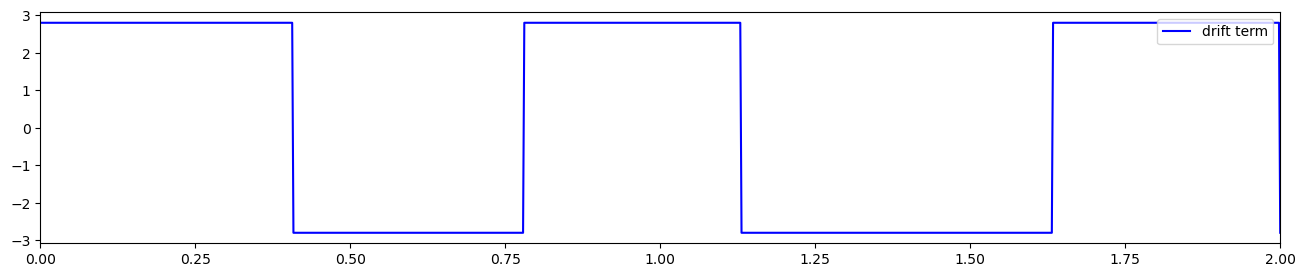

In [132]:

fig, ax = plt.subplots(figsize=(16,3))
ax.plot(ts, mu_pc(ts, mu1, mu2, endpoints), c='b', label='drift term')
ax.legend(loc='upper right')
ax.autoscale(axis='x', tight=True)
plt.show()

In [133]:
addm = aDDModel(rl, rr, theta, endpoints=endpoints, sigma=sigma)
trajs = addm.gen_trajs(z, T_end, num=1000)
ts = np.linspace(0, T_end, 1000)
EX = []
for t in ts:
    EX.append(z + mut_pl(t, mu1, mu2, endpoints))
    
avg = np.mean(trajs[:,1,:], axis=0)

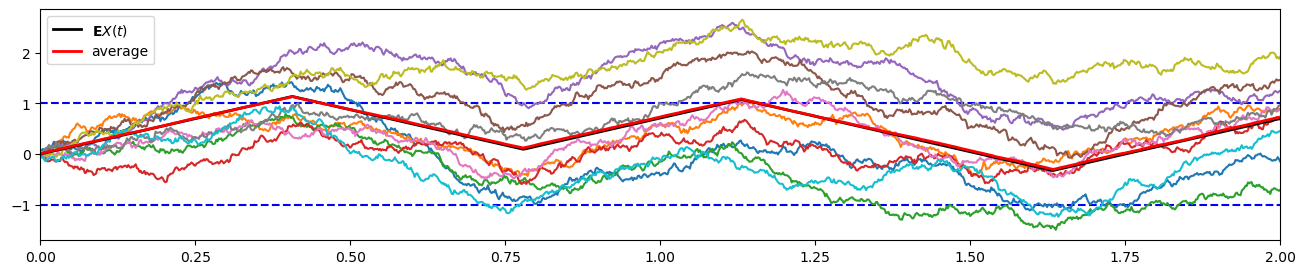

In [134]:
fig, ax = plt.subplots(figsize=(16,3))
ax.hlines(a, 0, 2, colors='blue', linestyles='--')
ax.hlines(-a, 0, 2, colors='blue', linestyles='--')
for traj in trajs[:10]:
    ax.plot(traj[0], traj[1])
ax.plot(ts, np.array(EX), c='k', label=r'$\mathbf{E}X(t)$', lw=2)
ax.plot(ts, avg[:-1], c='r', label=r'average', lw=2)
ax.autoscale(axis='x', tight=True)
ax.legend()
plt.show()

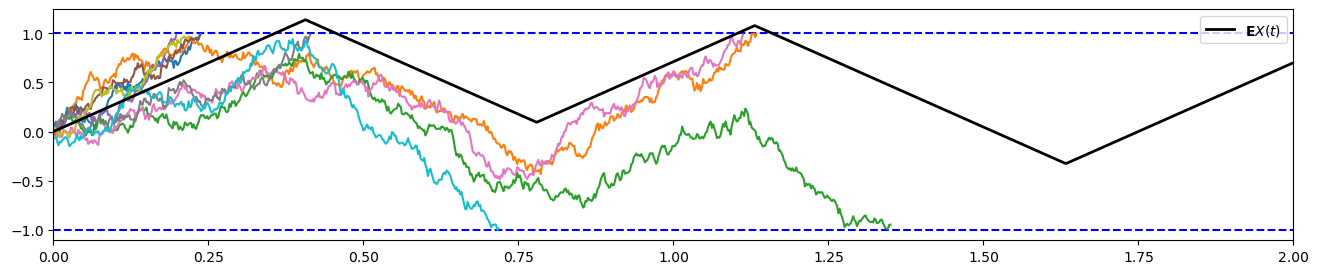

In [135]:
fig, ax = plt.subplots(figsize=(16,3))
ax.hlines(a, 0, 2, colors='blue', linestyles='--')
ax.hlines(-a, 0, 2, colors='blue', linestyles='--')
for traj in trajs[:10]:
    idx = np.argmax(np.logical_or(traj[1]>a, traj[1]<-a))
    ax.plot(traj[0, :idx], traj[1, :idx])
ax.plot(ts, np.array(EX), c='k', label=r'$\mathbf{E}X(t)$', lw=2)
ax.autoscale(axis='x', tight=True)
ax.legend()
plt.show()